# Clone repo

In [ ]:
%cd /content
!rm -rf gcn_vs_cnn
!git clone https://github.com/Chris1nexus/gcn_vs_cnn.git
%cd gcn_vs_cnn

# Dependencies installation

In [ ]:
!bash ./setup.sh

# Experiment section

## CNN experiment

In [ ]:
!python cnn_experiment.py --lr 0.00001 --format rgb --epochs 40 --cross-val false

## GradCAM plotting

In [ ]:
!python eval_gradcam.py  --vgg-weights-path /content/gcn_vs_cnn_bioinformatics/weights/best_model_torch_weights.pt --format rgb

## GCN experiment

In [ ]:
!python gcn_experiment.py  --lr 0.001 --dataset unet

## Unet segmentation only

In [ ]:
!python unet_experiment.py --lr 0.0001 --format gray --epochs 40  --weights-dir "./temporary_weights" --weights-fname "tmp_torch_weights.pt"

## (Proposed variation) Domain adaptation network training (AdaptUnet)

In [ ]:
!python cell_segmentation_experiment.py --epochs 40 --lr 0.0001 --weights-dir "./temporary_weights" --weights-fname "tmp_torch_weights.pt" 

## (Proposed variation) Unet segmentation on dataset preprocessed through domain adaptation unet (cells removed from the images)

In [ ]:
!python adaptation_experiment.py --epochs 10

In [ ]:
# uncomment if dataset is at a given location in  a drive folder
# use the copied content to then proceed (I/O directly with drive is slow, cp -r is needed to move it to current machine)
#from google.colab import drive
#drive.mount("/content/drive")
#!cp -r '/content/drive/MyDrive/BIO_project/vascular_segmentation' '/content/.'

# elastic transform plot 

In [ ]:
import matplotlib.pyplot as plt
from lib.managers import RCCDatasetManager
from lib.data.plot_utils import grid_plot_elastic_transform
datasetManager = RCCDatasetManager("./rccdataset",download_dataset=True,verbose=True)

(img_path, seg_path, img,seg,seg_gt), label = datasetManager.sample_dataset[60]

grid_plot_elastic_transform(img, seg_gt, alpha=(3,10), sigma=(0.08, 0.13), alpha_affine=(0.07, 0.13), random_state=None)


# download domain adaptation network weights from public drive id

In [ ]:
from lib.data.utils import DriveDownloader

weights_downloader = DriveDownloader()
weights_downloader.download_file_from_google_drive("15cbuIsknQAywkusaPve8qhkhLY3aowAR", "adaptunet_weights.pt")


# Plot graphs

In [ ]:
from lib.managers import RCCDatasetManager

datamanager = RCCDatasetManager("./rccdataset", download_dataset=True, verbose=Truet)

# Plot nx graphs


## plot gradcam result graphs

In [ ]:
# do the training and then produce gradcam outputs
!python cnn_experiment.py --lr 0.00001 --format rgb --epochs 40 --cross-val false
!python eval_gradcam.py  --vgg-weights-path /content/gcn_vs_cnn_bioinformatics/weights/best_model_torch_weights.pt --format rgb

In [ ]:
from processing_utils import ToGraphTransform
from image_utils import read_image, get_segmentation_mask, binarize_to_numpy, pil_loader
import pandas as pd
import cv2

# from the previous cell outputs, get back the mapping between gradcam and original samples (will be needed to find the original samples and plot their graph data structure)

df = pd.read_csv("/content/new/gcn_vs_cnn_bioinformatics/logs/reference_gradcam_logs.txt",sep=";")

graphs_and_masks = []
graph_transformer = ToGraphTransform()
for id, row in df.iterrows():
  
  curr_id = row['id']
  image_path = row['image_path']
  mask_path = row['mask_path']
  mask_img = read_image(mask_path, resize_dim=512,color_mapping = cv2.IMREAD_COLOR, img_format='RGB')
  uint8_mask = binarize_to_numpy(mask_img, cv2.IMREAD_COLOR, img_format='RGB')
  bin_mask = get_segmentation_mask(uint8_mask,cv2.IMREAD_COLOR, img_format='RGB')
  graphs_and_masks.append((curr_id, image_path, bin_mask,graph_transformer.graph_transform(uint8_mask)))




In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
import networkx as nx
import matplotlib.pyplot as plt


# take any of the graph_and_masks samples and get their id, image path, segmentation mask and graph item (data structure needed to store all
# that matters to represent it as data and also visually)

curr_id, image_path, bin_mask, graph_item = graphs_and_masks[5]

G = nx.Graph(graph_item.adjacencyMatrix)

A = to_agraph(G)
#print(A)
A.layout('dot')
A.draw('graph_dot_plot.png')
plt.figure(figsize=(14,14))

plt.figure(figsize=(12,12))
plt.imshow(ToGraphTransform.plot_all(graph_item))
plt.imshow(bin_mask, cmap='jet', alpha=0.2)

In [ ]:
from PIL import Image
import os
from IPython.display import display

# from any of the logs generated by the gradcam, plot any of the components of the abstract graph of that sample
logs_dir = "./logs"
curr_gradcam_path = os.path.join(logs_dir, f"gradcam_log_{curr_id}.png")

plt.figure(figsize=(12,12))
plt.imshow(pil_loader(image_path, resize_dim=512,color_mapping='RGB'))

# observe the component id by means of either the graph_dot_plot.png or networkx visualization
# and then pass it here to proceed with the visualization
component_idx = 6
plt.imshow(ToGraphTransform.highlight_component(graph_item,component_idx, comp_type='node_edges'), cmap='jet',alpha=0.2)
gradcam = Image.open(curr_gradcam_path)
display(gradcam)

In [ ]:
import numpy as np

# another visualization example
plt.figure(figsize=(12,12))
plt.imshow(pil_loader(image_path, resize_dim=512,color_mapping='RGB'))
node_edge_mask = ToGraphTransform.highlight_component(graph_item,69, comp_type='node_edges')
plt.imshow(bin_mask, cmap='jet')
plt.imshow(np.where(node_edge_mask > 0, 1, 0), cmap='jet',alpha=0.2)

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(ToGraphTransform.plot_all(graph_item))
plt.imshow(bin_mask, cmap='jet', alpha=0.2)

# Plot utilities to plot graphs of the dataset and their abstract representation

In [ ]:
from lib.data.processing_utils import ToGraphTransform
from lib.managers import RCCDatasetManager

datasetManager = RCCDatasetManager(None, download_dataset=True, verbose=True)

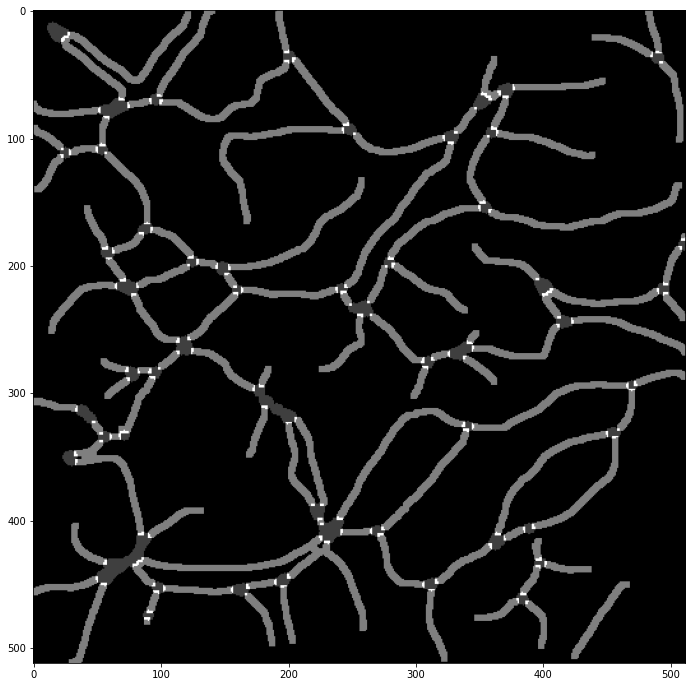

In [ ]:
import numpy as np

SAMPLE_IDX = 0
(img_path, seg_path, img,seg,seg_gt),label = datasetManager.sample_dataset[SAMPLE_IDX]


graphTransformer = ToGraphTransform()
seg_gt_uint8 = (seg_gt*255).astype(np.uint8)
graph_item = graphTransformer.graph_transform(seg_gt_uint8,log_procedure=True)

graphTransformer.plot_graph_creation_phases(graph_item)
plotted = graphTransformer.plot_all(graph_item)

fig = plt.figure(figsize=(12,12))
graph_fig = fig.add_subplot(111)
graph_fig.imshow(plotted, cmap='gray')
#graph_fig.imshow(seg_gt_uint8,cmap='jet', alpha=0.2)
plt.savefig("result.png")

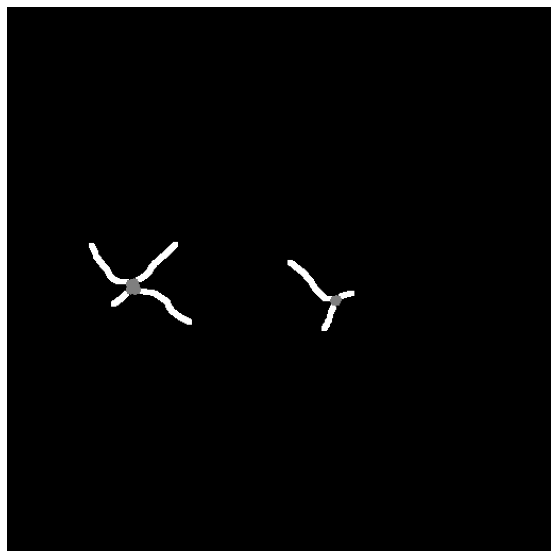

In [ ]:
res = graphTransformer.highlight_component(graph_item,26, comp_type='node_edges')
res = graphTransformer.highlight_component(graph_item,28, comp_type='node_edges',highlight_image=res)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(res,cmap='gray' )

# save image of the graph (A.draw('graph_item.png')) and plot a simpler but less readable alternative with nx.draw(...)

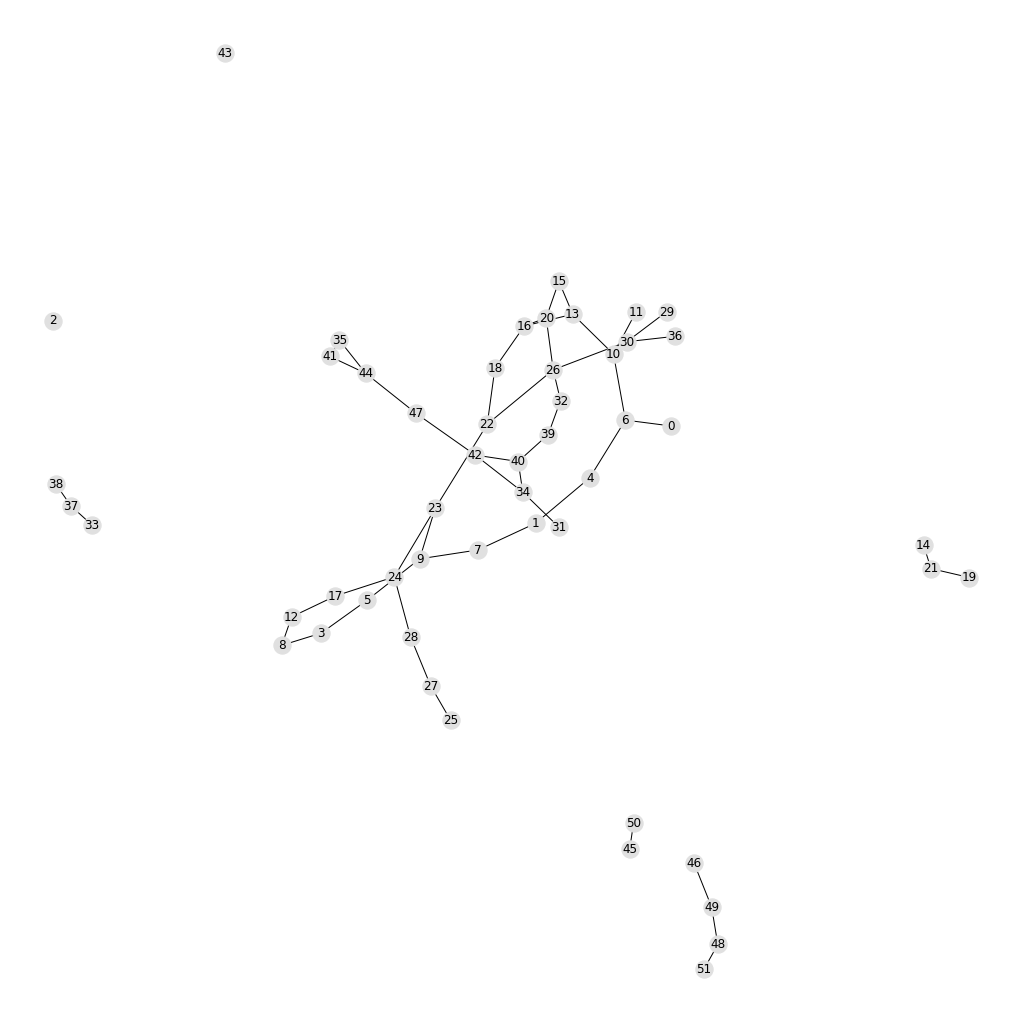

In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph(graph_item.adjacencyMatrix)

A = to_agraph(G)
#print(A)
A.layout('dot')
A.draw('graph_item.png')
plt.figure(figsize=(14,14))
nx.draw(G,node_color='#e0e0e0',with_labels=True)
